In [1]:
from torch.distributions.uniform import Uniform

from main import train_and_eval, train_loader, test_loader

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch

### Visualize training and testing data

In [2]:
for x in train_loader:
    break
    
for y in test_loader:
    break
    
x.size(), y.size()

(torch.Size([128, 1, 20, 20]), torch.Size([128, 1, 20, 20]))

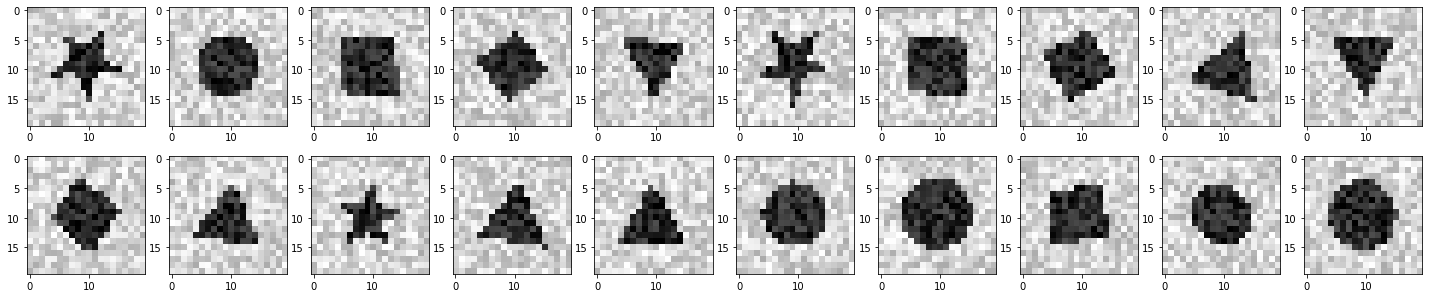

In [3]:
_, axes = plt.subplots(2,10,figsize=(25,5))
for i in range(10):
    axes[0][i].imshow(x[i].squeeze().numpy(), 'gray')
    axes[1][i].imshow(y[i].squeeze().numpy(), 'gray')

In [4]:
y.max()

tensor(0.7500)

### Train the flow model

In [5]:
target_distribution = Uniform(0,1)
flow, train_losses, test_losses = train_and_eval(1, 1e-3, train_loader, test_loader, target_distribution)

Starting epoch: 0 of 1
Loss at iteration 0 is 1.091446876525879


KeyboardInterrupt: 

In [ ]:
train_losses, test_losses

In [ ]:
_ = plt.plot(train_losses)
_ = plt.plot(test_losses)

### Sample from the trained model

In [ ]:
import torch
from model import AutoRegressiveFlow
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

flow = AutoRegressiveFlow(1, num_layers=5, n_components=10)

In [ ]:
flow.load_state_dict(torch.load('trained_weights.pt', map_location='cpu'))

In [ ]:
from torch.distributions.normal import Normal

def sample(flow, num_samples):
    n_channels, height, width = 1, 20, 20
    result = torch.zeros(num_samples, n_channels, height, width)
    with torch.no_grad():
        for row in range(height):
            for col in range(width):
                for channel in range(n_channels):
                    model_output = flow.model(result)
                    mus, log_sigmas, weight_logits = torch.chunk(model_output, 3, dim=1)
                    
                    mus = mus.view(num_samples, flow.n_components, n_channels, height, width)
                    log_sigmas = log_sigmas.view(num_samples, flow.n_components, n_channels, height, width)
                    weight_logits = weight_logits.view(num_samples, flow.n_components, n_channels, height, width)
                    
                    # get the mus, sigmas and weights for pixel at (channel, row, col)
                    mus = mus[:,:,channel, row, col]
                    log_sigmas = log_sigmas[:,:,channel, row, col]
                    weight_logits = weight_logits[:,:,channel, row, col]
                    weights = weight_logits.softmax(dim=1)
                    
                    # a sample at (channel, row, col) comes from a mixture of Gaussians
                    # where the probability of the Gaussian `i` is given by `weights[i]`
                    indices_of_gaussians_to_sample_from = torch.multinomial(weights, 1).squeeze(-1)
                    zero_to_num_samples = torch.arange(num_samples)
                    mus_per_batch = mus[zero_to_num_samples, indices_of_gaussians_to_sample_from]
                    sigmas_per_batch = log_sigmas[zero_to_num_samples, indices_of_gaussians_to_sample_from].exp()
                    result[:, channel, row, col] = torch.normal(mus_per_batch, sigmas_per_batch)
    return result

In [ ]:
out = sample(flow, 10)
_, axes = plt.subplots(1,10,figsize=(20,5))

for i in range(10):
    _ = axes[i].imshow((out[i].squeeze().numpy()).astype(np.float32), 'gray')

In [ ]:
out.mean()

In [ ]:
x = torch.randn(16,1,20,20)
with torch.no_grad():
    y,z = flow(x)

In [ ]:
y.size(), z.size()

In [ ]:
y.min(), y.max()

In [ ]:
z.min(), z.max()

In [ ]:
-z.mean()

### Debug what's wrong

In [7]:
from main import train_and_eval, train_loader, test_loader
from model import AutoRegressiveFlow
flow = AutoRegressiveFlow(1, num_layers=5, n_components=10)
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)

for x in train_loader:
    _, y = flow(x)
    loss = -y.mean()
    if loss.item() < 0:
        print(loss.item())
        break
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

-0.04001988470554352


In [9]:
flow(x)[1].mean()

tensor(0.0400, grad_fn=<MeanBackward0>)

In [10]:
with torch.no_grad():
    mus, log_sigmas, weight_logits = torch.chunk(flow.model(x), 3, dim=1)

In [11]:
mus.size(), log_sigmas.size(), weight_logits.size()

(torch.Size([128, 10, 20, 20]),
 torch.Size([128, 10, 20, 20]),
 torch.Size([128, 10, 20, 20]))

In [12]:
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

In [13]:
weights = weight_logits.softmax(dim=1)
weights.size()

torch.Size([128, 10, 20, 20])

In [14]:
dist = Normal(mus.view(128,10,1,20,20), log_sigmas.exp().view(128,10,1,20,20))
x.size()

torch.Size([128, 1, 20, 20])

In [16]:
x.unsqueeze(1).size()

torch.Size([128, 1, 1, 20, 20])

In [21]:
(dist.cdf(x.unsqueeze(1)) * weights.view(128,10,1,20,20)).sum(1).max()

tensor(0.9844)

In [26]:
(dist.log_prob(x.unsqueeze(1)).exp() * weights.view(128,10,1,20,20)).sum(1).max()

tensor(2.8258)

In [28]:
dist.log_prob(x.unsqueeze(1)).exp().max()

tensor(15.2483)

In [39]:
a = Normal(0, 0.01)
a.log_prob(0).exp()

tensor(39.8942)

In [104]:
mus = torch.arange(6).view(2,1,3).float()
# sigmas = torch.ones(1,2,3)
sigmas = torch.ones(2,1,3)
a = Normal(mus, sigmas)
x = torch.FloatTensor([[1.0], [4.0]]).view(1,1,2,1).repeat(2,1,1,1)
print('x.size() is', x.size())
y = a.log_prob(x).exp()
print('y.size() is', y.size())
y

x.size() is torch.Size([2, 1, 2, 1])
y.size() is torch.Size([2, 2, 2, 3])


tensor([[[[2.4197e-01, 3.9894e-01, 2.4197e-01],
          [1.3383e-04, 4.4318e-03, 5.3991e-02]],

         [[5.3991e-02, 4.4318e-03, 1.3383e-04],
          [2.4197e-01, 3.9894e-01, 2.4197e-01]]],


        [[[2.4197e-01, 3.9894e-01, 2.4197e-01],
          [1.3383e-04, 4.4318e-03, 5.3991e-02]],

         [[5.3991e-02, 4.4318e-03, 1.3383e-04],
          [2.4197e-01, 3.9894e-01, 2.4197e-01]]]])

In [63]:
a.mean.size(), a.scale.size()

(torch.Size([2, 1, 3]), torch.Size([2, 1, 3]))

In [70]:
y

tensor([[[2.4197e-01, 3.9894e-01, 2.4197e-01],
         [1.3383e-04, 4.4318e-03, 5.3991e-02]],

        [[5.3991e-02, 4.4318e-03, 1.3383e-04],
         [2.4197e-01, 3.9894e-01, 2.4197e-01]]])

In [81]:
x.repeat(2,1,3)

tensor([[[1., 1., 1.],
         [4., 4., 4.]],

        [[1., 1., 1.],
         [4., 4., 4.]]])

In [85]:
a.log_prob(x.repeat(2,1,3)).exp()

tensor([[[2.4197e-01, 3.9894e-01, 2.4197e-01],
         [1.3383e-04, 4.4318e-03, 5.3991e-02]],

        [[5.3991e-02, 4.4318e-03, 1.3383e-04],
         [2.4197e-01, 3.9894e-01, 2.4197e-01]]])

In [110]:
mus = torch.arange(6).view(2,1,3).float()
# sigmas = torch.ones(1,2,3)
sigmas = torch.ones(2,1,3)
a = Normal(mus, sigmas)
x = torch.FloatTensor([[1.0], [4.0]]).view(1,2,1).repeat(2,1,1)
w = torch.FloatTensor([[1.0], [4.0]]).view(1,2,1)
print('x.size() is', x.size())
y = a.log_prob(x).exp()
z = a.log_prob(w).exp()
print('y.size() is', y.size(), 'z.size() is', z.size())
y

x.size() is torch.Size([2, 2, 1])
y.size() is torch.Size([2, 2, 3]) z.size() is torch.Size([2, 2, 3])


tensor([[[2.4197e-01, 3.9894e-01, 2.4197e-01],
         [1.3383e-04, 4.4318e-03, 5.3991e-02]],

        [[5.3991e-02, 4.4318e-03, 1.3383e-04],
         [2.4197e-01, 3.9894e-01, 2.4197e-01]]])

In [111]:
z

tensor([[[2.4197e-01, 3.9894e-01, 2.4197e-01],
         [1.3383e-04, 4.4318e-03, 5.3991e-02]],

        [[5.3991e-02, 4.4318e-03, 1.3383e-04],
         [2.4197e-01, 3.9894e-01, 2.4197e-01]]])